# ARIMA and SARIMA

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
import numpy as np

In [2]:
df = pd.read_csv("data/champagne.csv")
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [3]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.set_index('Month', inplace = True)
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


## Seasonal decompose

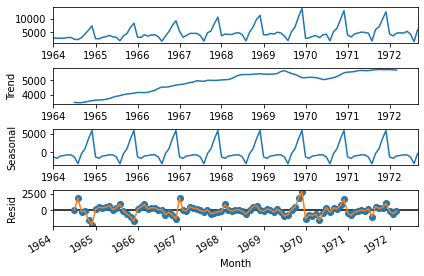

In [8]:
result_add = seasonal_decompose(df, model='additive')
result_add.plot();
result_add.resid.plot();

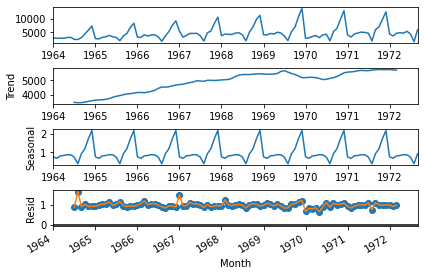

In [9]:
result_mul = seasonal_decompose(df, model='multiplicative')
result_mul.plot();
result_mul.resid.plot();

In [14]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multipl resid: ', adfuller(result_mul.resid.dropna())[1])

additive resid:  0.0004045725636879178
multipl resid:  3.4057721891957533e-16


## ARIMA

/home/soutobias/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/soutobias/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


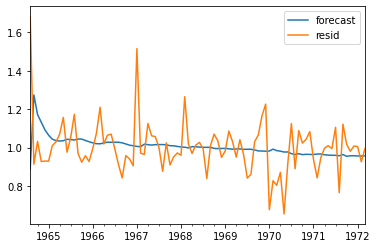

In [14]:
arima = ARIMA(result_mul.resid.dropna(), order=(1,1,1))
arima = arima.fit()
arima.plot_predict();

## SARIMA

In [15]:
df_train = df[df.index < '1969']
df_test = df[df.index >= '1969']

0.3639157716602452


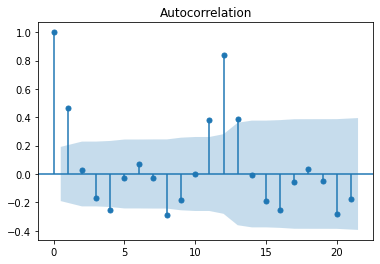

In [18]:
print(adfuller(df['Sales'])[1])
plot_acf(df.dropna());

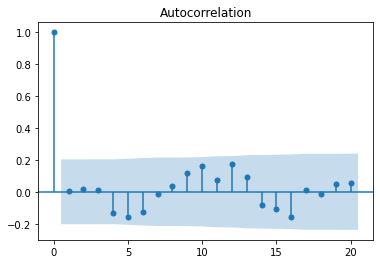

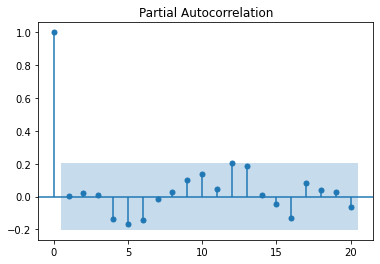

In [25]:
plot_acf(result_mul.resid.dropna());
plot_pacf(result_mul.resid.dropna());

Differencing

2.9236742492530776e-09


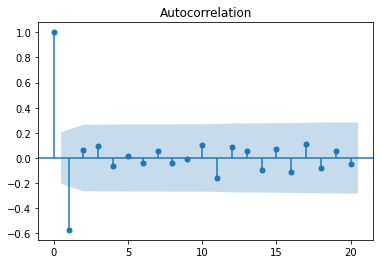

In [21]:
differenced = result_mul.resid.diff(1).diff(1)
print(adfuller(differenced.dropna())[1])
plot_acf(differenced.dropna());

### RUN MODEL

In [29]:
smodel = pm.auto_arima(df_train[['Sales']], seasonal=True, m=12, D=1, 
                       start_p=0, max_p=2, max_d=1, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True, n_jobs=-1)

/home/soutobias/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=760.006, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=762.448, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=761.995, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=779.115, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=760.237, Time=0.25 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=760.647, Time=0.15 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=762.825, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=761.018, Time=0.10 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=760.629, Time=0.10 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=758.097, Time=0.18 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=763.760, Time=0.12 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=764.104, Time=0.30 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=763.632, Time=0.06 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   

In [33]:
smodel.fit(df_train)
pred = smodel.predict(n_periods=len(df_test), alpha=0.05, return_conf_int=True)

In [34]:
y_test = pd.DataFrame(np.array([pred[0], pred[1].T[0], pred[1].T[1]]).T, columns=['central', 'upper', 'lower'])
y_test.index = df_test.index
central = y_test['central']
upper_series = y_test['upper']
lower = y_test['lower']

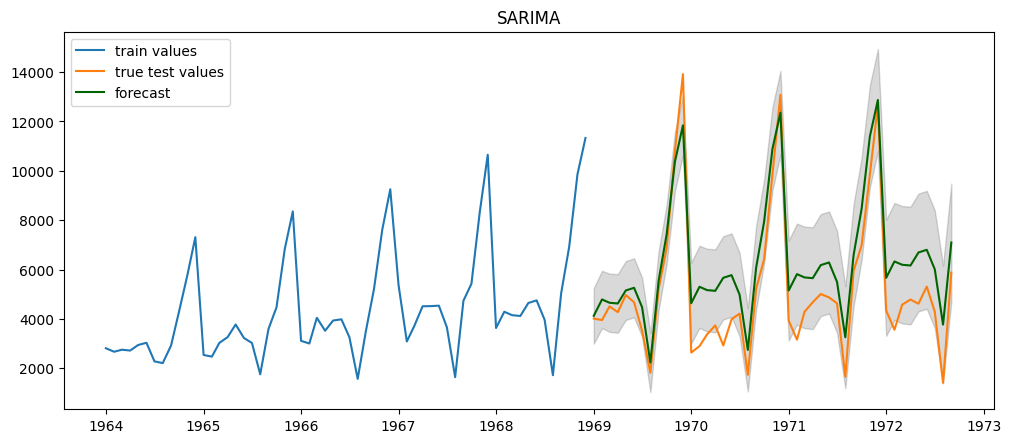

In [35]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA")
plt.legend()
plt.show()